In [2]:
#importing packages for data manuplation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

#for easy access to path
import sys
import os

import warnings
warnings.filterwarnings('ignore')
import dvc.api

In [3]:
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts_/')

In [4]:
#import packages for machine learning operation
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier

#import modules from script
from decision_tree import handler
from decision_tree import DecisionTreesModel
from XGboost import boost
from regression import Logistic
from helper import Helper

from app_logger import App_Logger

In [5]:
pd.set_option('max_column', None)
pd.set_option('max_rows', None)
#read csv file
df = pd.read_csv('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [6]:
#Users who responded to the questionaries
answered_df = df.copy(deep=True)
answered_df = answered_df[answered_df['yes'] == 1].append(answered_df[answered_df['no'] == 1])

In [7]:
control_df = answered_df[answered_df['experiment'] == 'control']
exposed_df = answered_df[answered_df['experiment'] == 'exposed']


In [8]:
# Forming a combined DataFrame substituting the yes and no column to response and having only 1 and 0 as values where 1 translates to a yes and 0 to no
#All users who answered yes
all_yes_df = control_df[control_df['yes'] == 1].append(exposed_df[exposed_df['yes'] == 1])
all_yes_df = all_yes_df.drop(['yes','no'], axis = 1)
all_yes_df['response'] = 1
#All users who answered no
all_no_df = control_df[control_df['no'] == 1].append(exposed_df[exposed_df['no'] == 1])
all_no_df = all_no_df.drop(['yes','no'], axis = 1)
all_no_df['response'] = 0
#Final Combined dataframe will be
combined_df = all_yes_df.append(all_no_df)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,4e0c6839-9da6-4291-a45c-31e0bda501a8,exposed,2020-07-04,8,Generic Smartphone,6,Chrome Mobile,0
1,cc35027c-4113-4b3d-809d-659083a91d13,exposed,2020-07-03,9,Generic Smartphone,6,Chrome Mobile,0
2,94217fb4-06db-43b2-a9fe-504e2a284f85,exposed,2020-07-10,1,Samsung SM-A920F,6,Chrome Mobile WebView,0
3,d5ff5e67-bbe1-43cf-9e12-1b18b27fd009,exposed,2020-07-09,20,Generic Smartphone,6,Chrome Mobile,1
4,dd5b63f1-b5a3-4b6b-a894-8510452b62d5,exposed,2020-07-07,13,Samsung SM-A600FN,6,Facebook,1


>Extracting all who responded either yes or no to one column

### Encoding categorical variables using Label Encoder

In [9]:
def encode_labels(combined_df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    response_encoder = preprocessing.LabelEncoder()
    
    combined_df['date'] = date_encoder.fit_transform(combined_df['date'])
    combined_df['device_make'] = device_encoder.fit_transform(combined_df['device_make'])
    combined_df['browser'] = browser_encoder.fit_transform(combined_df['browser'])
    combined_df['experiment'] = experiment_encoder.fit_transform(combined_df['experiment'])
    combined_df['browser'] = response_encoder.fit_transform(combined_df['browser'])
    combined_df['response'] = response_encoder.fit_transform(combined_df['response'])


    
    return combined_df

In [10]:
combined_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,4e0c6839-9da6-4291-a45c-31e0bda501a8,exposed,2020-07-04,8,Generic Smartphone,6,Chrome Mobile,0
1,cc35027c-4113-4b3d-809d-659083a91d13,exposed,2020-07-03,9,Generic Smartphone,6,Chrome Mobile,0
2,94217fb4-06db-43b2-a9fe-504e2a284f85,exposed,2020-07-10,1,Samsung SM-A920F,6,Chrome Mobile WebView,0
3,d5ff5e67-bbe1-43cf-9e12-1b18b27fd009,exposed,2020-07-09,20,Generic Smartphone,6,Chrome Mobile,1
4,dd5b63f1-b5a3-4b6b-a894-8510452b62d5,exposed,2020-07-07,13,Samsung SM-A600FN,6,Facebook,1


## Modeling Training


In [11]:
def feature_data(cleaned_df):
    
    broweser_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]
    platfrom_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]

    return broweser_df, platfrom_df

In [12]:
def save_encoded_df(encoded_df):
    
    browser_df, platfrom_df = feature_data(encoded_df)
    browser_df.to_csv('../data/browser.csv', index=False)
    platfrom_df.to_csv('../data/platform.csv', index=False)

In [13]:
encoded_df = encode_labels(combined_df)
save_encoded_df(encoded_df)

In [16]:
browser_df = combined_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]

In [17]:
browser_df=browser_df.to_csv("../data2/AdSmartABdata.csv")


In [18]:
# versioning browser 
path = 'data2/AdSmartABdata.csv'
repo = 'https://github.com/Melak2017/abtest-mlops'
rev = 'browser-v1'
data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
collected_data = pd.read_csv(data_url)


In [23]:
platfrom_df = combined_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]

In [24]:
platfrom_df= platfrom_df.to_csv("../data2/AdSmartABdata.csv")


In [25]:
# versioning platform
path = 'data2/AdSmartABdata.csv'
repo = 'https://github.com/Melak2017/abtest-mlops'
rev = 'platform-v1'
data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
collected_data = pd.read_csv(data_url)

#### Decision Tree

In [26]:
def read_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        self.logger.info(f"Model loaded from {file_name}.pkl")
        return pickle.load(f)

def write_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        self.logger.info(f"Model dumped to {file_name}.pkl")
        pickle.dump(model, f)


In [28]:
browser_df = combined_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [29]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)


step 0: Validation Accuracy of DecisionTreesModel is: 0.558
step 0: Validation Loss of DecisionTreesModel is: 0.665

step 1: Validation Accuracy of DecisionTreesModel is: 0.567
step 1: Validation Loss of DecisionTreesModel is: 0.658

step 2: Validation Accuracy of DecisionTreesModel is: 0.549
step 2: Validation Loss of DecisionTreesModel is: 0.671

step 3: Validation Accuracy of DecisionTreesModel is: 0.475
step 3: Validation Loss of DecisionTreesModel is: 0.724

step 4: Validation Accuracy of DecisionTreesModel is: 0.484
step 4: Validation Loss of DecisionTreesModel is: 0.718



step 1: Test Accuracy of DecisionTreesModel is: 0.520
Test Metrics
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        86
           1       0.29      0.38      0.33        39

    accuracy                           0.52       125
   macro avg       0.48      0.48      0.48       125
weighted avg       0.56      0.52      0.53       125

Loss on test data is: 0.693
Test accuracy on test data is: 0.520



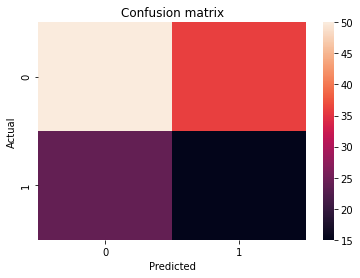

In [30]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print(f"Test accuracy on test data is: {test_acc:.3f}")
print()

In [31]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.029170
1,hour,0.378189
2,date,0.157551
3,device_make,0.294640
4,browser,0.140450


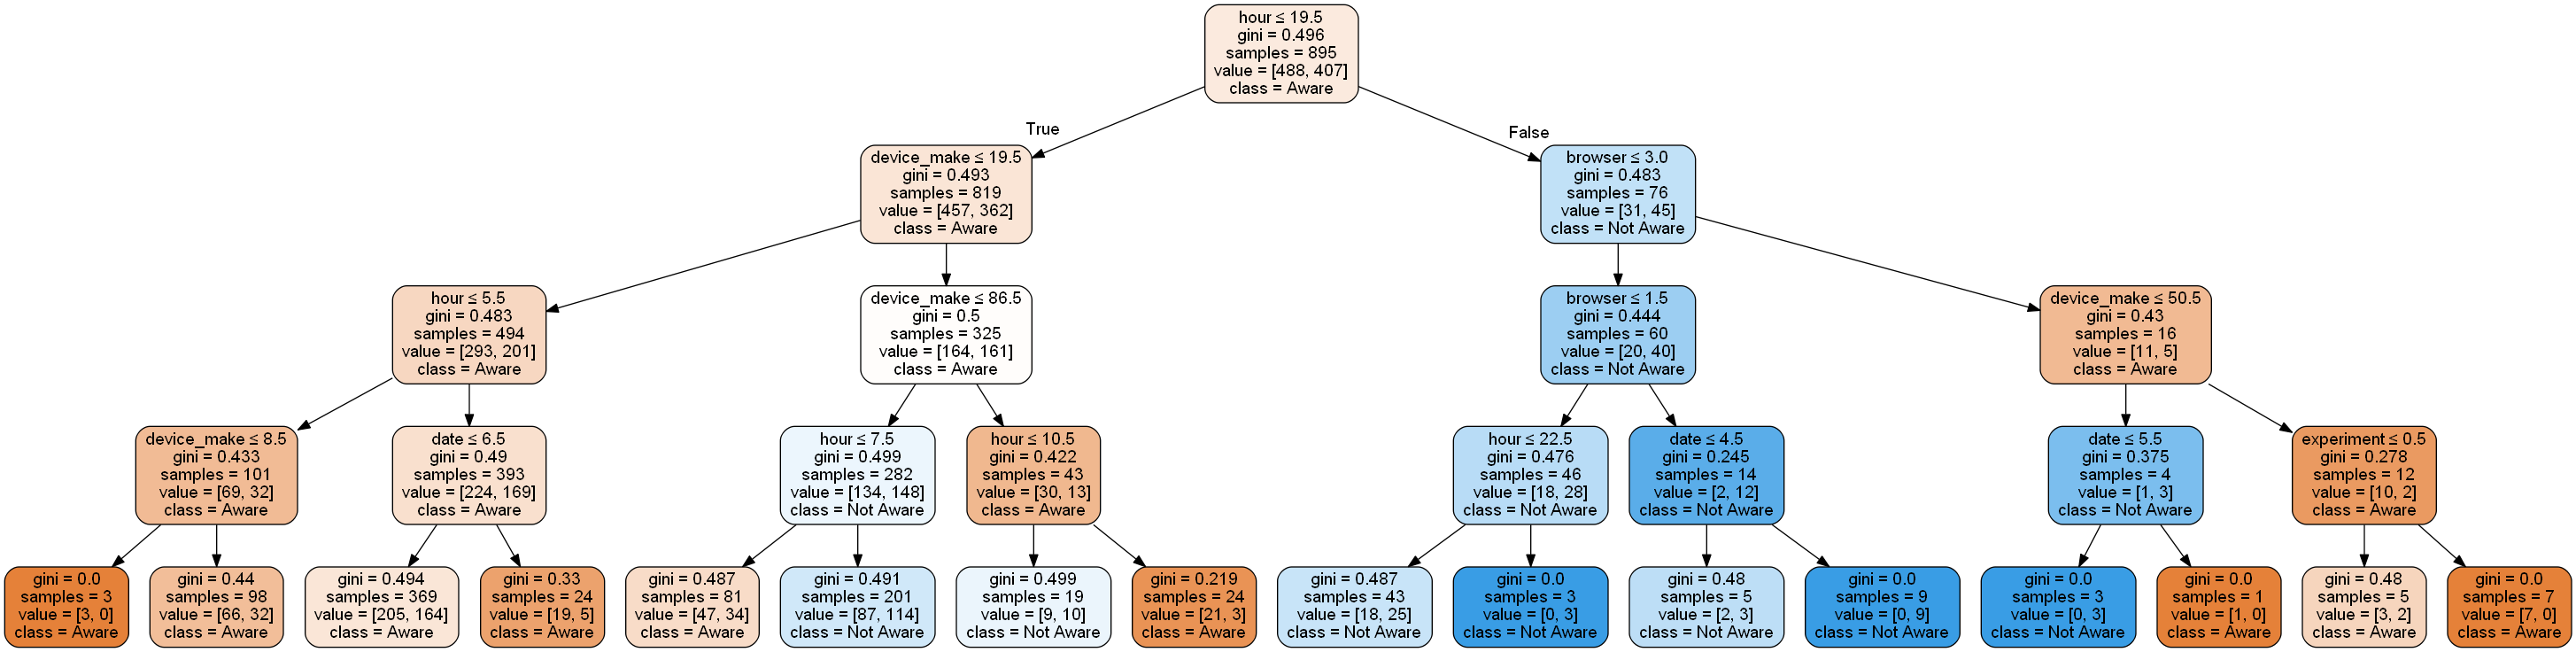

In [32]:
import pydotplus
#import graphviz
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

##### Decision tree by platform

In [35]:
platfrom_df = combined_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platfrom_df[feature_cols]
y = platfrom_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [36]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)



step 0: Validation Accuracy of DecisionTreesModel is: 0.545
step 0: Validation Loss of DecisionTreesModel is: 0.675

step 1: Validation Accuracy of DecisionTreesModel is: 0.571
step 1: Validation Loss of DecisionTreesModel is: 0.655

step 2: Validation Accuracy of DecisionTreesModel is: 0.549
step 2: Validation Loss of DecisionTreesModel is: 0.671

step 3: Validation Accuracy of DecisionTreesModel is: 0.471
step 3: Validation Loss of DecisionTreesModel is: 0.727

step 4: Validation Accuracy of DecisionTreesModel is: 0.475
step 4: Validation Loss of DecisionTreesModel is: 0.724



step 1: Test Accuracy of DecisionTreesModel is: 0.512
Test Metrics
              precision    recall  f1-score   support

           0       0.68      0.57      0.62        87
           1       0.27      0.37      0.31        38

    accuracy                           0.51       125
   macro avg       0.48      0.47      0.47       125
weighted avg       0.55      0.51      0.53       125

Loss on test data is: 0.699



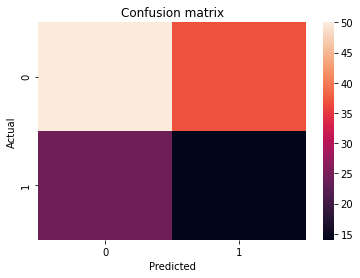

In [37]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [38]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.383212
2,date,0.120366
3,device_make,0.496422
4,platform_os,0.000000


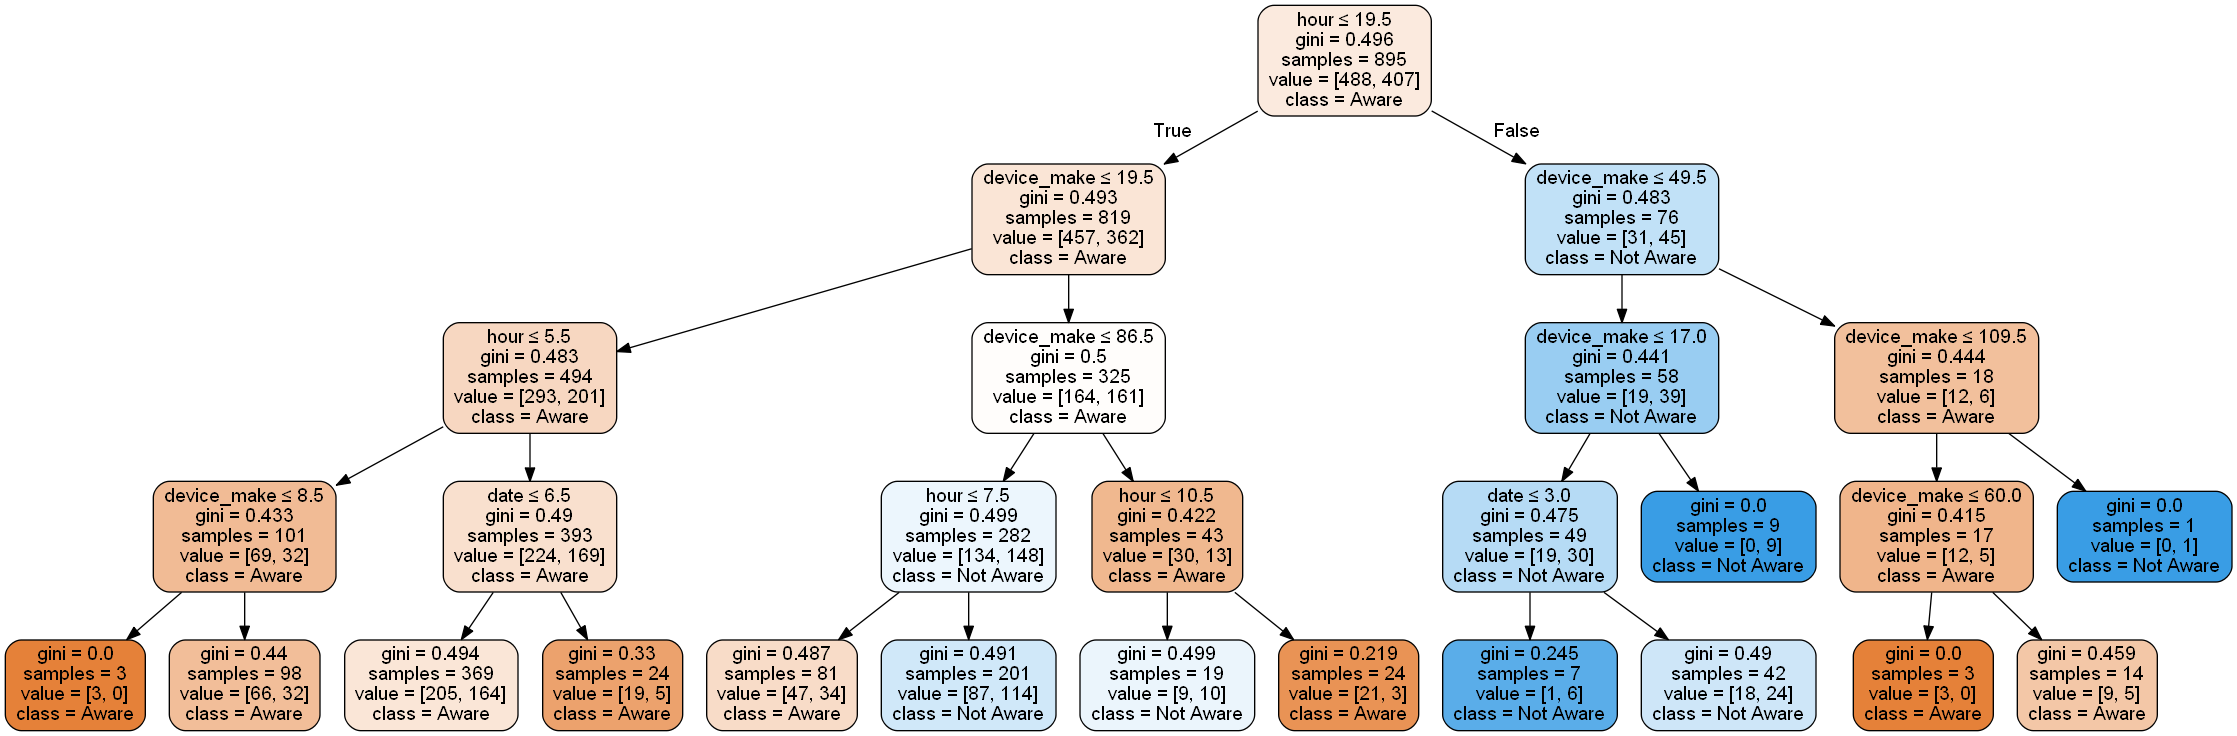

In [39]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')
Image(graph.create_png())

#### Logestic Regression

In [40]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [41]:
Logistic = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = Logistic.train(folds)


step 0: Validation Accuracy of LogesticRegression is: 0.504
step 0: Validation Loss of LogesticRegression is: 0.704

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.513
step 2: Validation Loss of LogesticRegression is: 0.698

step 3: Validation Accuracy of LogesticRegression is: 0.507
step 3: Validation Loss of LogesticRegression is: 0.702

step 4: Validation Accuracy of LogesticRegression is: 0.480
step 4: Validation Loss of LogesticRegression is: 0.721



step 1: Test Accuracy of LogesticRegression is: 0.584
Test Metrics
              precision    recall  f1-score   support

           0       0.84      0.61      0.70       102
           1       0.22      0.48      0.30        23

    accuracy                           0.58       125
   macro avg       0.53      0.54      0.50       125
weighted avg       0.72      0.58      0.63       125



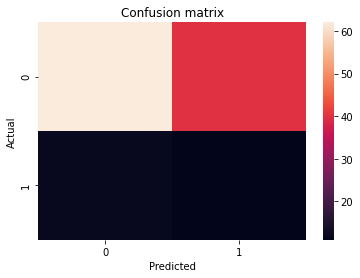

In [42]:
test_acc2, test_loss2, report2, matrix2  = Logistic.test()

In [43]:
p_values_df = Logistic.get_p_values()
p_values_df



,features,p_values
0,experiment,0.320379
1,hour,0.000451
2,date,0.152302
3,device_make,0.229621
4,browser,0.397554


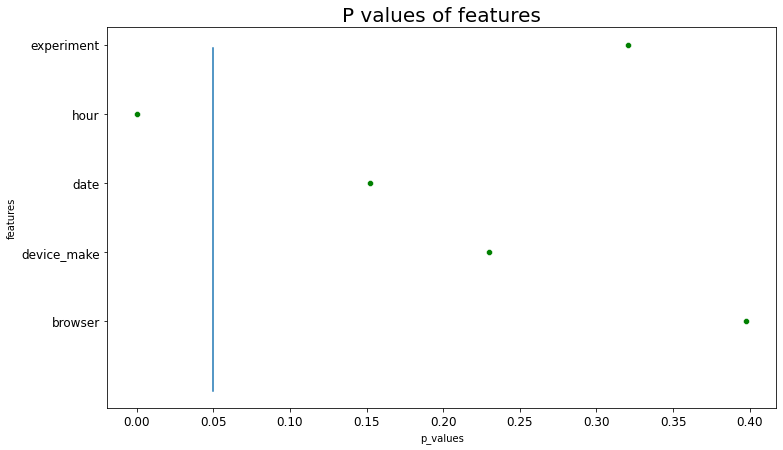

In [44]:
p_value_fig = Logistic.plot_pvalues(p_values_df)

In [46]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platfrom_df[feature_cols]
y = platfrom_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [47]:
Logistic = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = Logistic.train(folds)


TypeError: 'Logistic' object is not callable

step 1: Test Accuracy of LogesticRegression is: 0.584
Test Metrics
              precision    recall  f1-score   support

           0       0.84      0.61      0.70       102
           1       0.22      0.48      0.30        23

    accuracy                           0.58       125
   macro avg       0.53      0.54      0.50       125
weighted avg       0.72      0.58      0.63       125



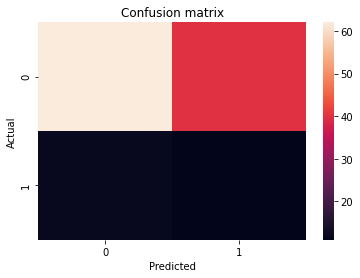

In [48]:
test_acc2, test_loss2, report2, matrix2  = Logistic.test()

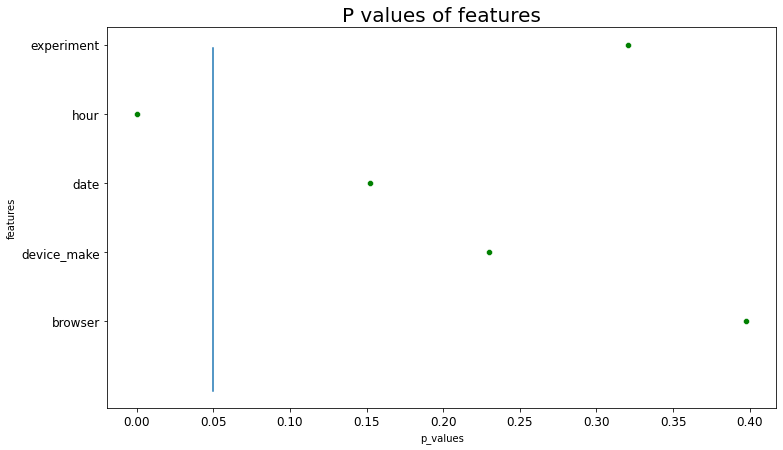

,features,p_values
0,experiment,0.320379
1,hour,0.000451
2,date,0.152302
3,device_make,0.229621
4,browser,0.397554


In [49]:
p_values_df = Logistic.get_p_values()
p_value_fig = Logistic.plot_pvalues(p_values_df)
p_values_df

#### XGboost Model

In [50]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [51]:
boost = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = boost.train(folds)



step 0: Validation Accuracy of GradientBoostingClassifier is: 0.536
step 0: Validation Loss of GradientBoostingClassifier is: 0.681

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.562
step 1: Validation Loss of GradientBoostingClassifier is: 0.661

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.549
step 2: Validation Loss of GradientBoostingClassifier is: 0.671

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.525
step 3: Validation Loss of GradientBoostingClassifier is: 0.689

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.484
step 4: Validation Loss of GradientBoostingClassifier is: 0.718



step 1: Test Accuracy of GradientBoostingClassifier is: 0.512
Test Metrics
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        91
           1       0.24      0.35      0.28        34

    accuracy                           0.51       125
   macro avg       0.47      0.46      0.46       125
weighted avg       0.58      0.51      0.54       125

Loss on test data is: 0.699



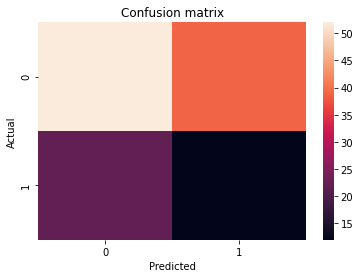

In [52]:
test_acc, loss, report, confusion_matrix = boost.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [53]:
boost.get_feature_importance()

,feature,feature_importances
0,experiment,0.037651
1,hour,0.242134
2,date,0.138397
3,device_make,0.494689
4,browser,0.087129


In [55]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platfrom_df[feature_cols]
y = platfrom_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [56]:
boost = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = boost.train(folds)


TypeError: 'boost' object is not callable

step 1: Test Accuracy of GradientBoostingClassifier is: 0.512
Test Metrics
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        91
           1       0.24      0.35      0.28        34

    accuracy                           0.51       125
   macro avg       0.47      0.46      0.46       125
weighted avg       0.58      0.51      0.54       125

Loss on test data is: 0.699



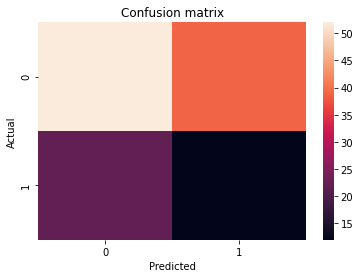

In [57]:
test_acc, loss, report, confusion_matrix = boost.test()
print(f"Loss on test data is: {loss:.3f}")
print()

##### Hyper parameter for decision tress